In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable

# load data

In [3]:
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
#                        transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=256, shuffle=True)

In [4]:
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./data', train=False, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
#                        transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=256, shuffle=True)

In [5]:
image, label = iter(train_loader).next()
image.__class__, label.__class__, image.size(), label.size()

(torch.FloatTensor,
 torch.LongTensor,
 torch.Size([256, 1, 28, 28]),
 torch.Size([256]))

## visualization

In [6]:
import matplotlib.pyplot as plt
import numpy as np
from torchvision.utils import make_grid
%matplotlib inline

In [7]:
make_grid(image[:5]).numpy().shape

(3, 32, 152)

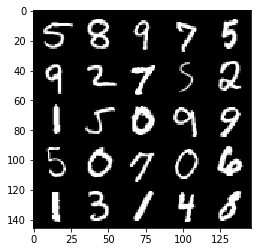

In [8]:
img = make_grid(image[:25], nrow=5, padding=1).numpy()
t = np.transpose(img, (1, 2, 0))
plt.imshow(t)

# train

In [9]:
class MultiLayerPerceptron(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        # layerの定義
        super(MultiLayerPerceptron, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

In [10]:
model = MultiLayerPerceptron(input_size=784, hidden_size=500, num_classes=10).cuda()
image = image.view(-1, 28 * 28)

# model()

In [11]:
model

MultiLayerPerceptron(
  (fc1): Linear(in_features=784, out_features=500, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=500, out_features=10, bias=True)
)

In [12]:
optimizer = optim.SGD(model.parameters(), lr=0.001)

def train(train_loader):
    model.train()
    train_loss = 0
    for batch_idx, (x, y) in enumerate(train_loader):
        x, y = x.view(-1, 28 * 28).cuda(), y.cuda()
        b_x = Variable(x)
        b_y = Variable(y)
        
        optimizer.zero_grad()
        output = model(b_x)
        loss = F.cross_entropy(output, b_y)
        train_loss += loss.data[0]
        loss.backward()
        optimizer.step()
        
    train_loss = train_loss / len(train_loader)
    return train_loss

def valid(test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    total = 0
    for x, y in test_loader:
        x, y = x.view(-1, 28 * 28).cuda(), y.cuda()
        b_x = Variable(x, volatile=True)
        b_y = Variable(y, volatile=True)
        
        outputs = model(b_x)
        test_loss += F.cross_entropy(outputs, b_y).data[0]
#         _, predicted = torch.max(outputs.data, 1)
#         correct += (predicted == b_y.data).sum()
        pred = outputs.data.max(1, keepdim=True)[1]
        correct += pred.eq(b_y.data.view_as(pred)).cpu().sum()
        total += b_y.size(0)
        
    val_loss = test_loss / len(test_loader)
    val_acc = correct / total
    return val_loss, val_acc

In [13]:
loss_list = []
val_loss_list = []
val_acc_list = []

for epoch in range(100):
    loss = train(train_loader)
    val_loss, val_acc = valid(test_loader)
    print('epoch %d, loss: %.4f val_loss: %.4f val_acc: %.4f' % (epoch, loss, val_loss, val_acc))
    
    # logging
    loss_list.append(loss)
    val_loss_list.append(val_loss)
    val_acc_list.append(val_acc)

epoch 0, loss: 2.2717 val_loss: 2.2419 val_acc: 0.3205
epoch 1, loss: 2.2156 val_loss: 2.1841 val_acc: 0.4827
epoch 2, loss: 2.1587 val_loss: 2.1239 val_acc: 0.5919
epoch 3, loss: 2.0986 val_loss: 2.0595 val_acc: 0.6657
epoch 4, loss: 2.0338 val_loss: 1.9910 val_acc: 0.7052
epoch 5, loss: 1.9643 val_loss: 1.9146 val_acc: 0.7260
epoch 6, loss: 1.8897 val_loss: 1.8391 val_acc: 0.7370
epoch 7, loss: 1.8112 val_loss: 1.7597 val_acc: 0.7484
epoch 8, loss: 1.7296 val_loss: 1.6718 val_acc: 0.7562
epoch 9, loss: 1.6464 val_loss: 1.5871 val_acc: 0.7628
epoch 10, loss: 1.5637 val_loss: 1.5082 val_acc: 0.7698
epoch 11, loss: 1.4829 val_loss: 1.4229 val_acc: 0.7779
epoch 12, loss: 1.4053 val_loss: 1.3452 val_acc: 0.7847
epoch 13, loss: 1.3316 val_loss: 1.2749 val_acc: 0.7911
epoch 14, loss: 1.2628 val_loss: 1.2059 val_acc: 0.7972
epoch 15, loss: 1.1994 val_loss: 1.1509 val_acc: 0.8062
epoch 16, loss: 1.1409 val_loss: 1.0913 val_acc: 0.8124
epoch 17, loss: 1.0877 val_loss: 1.0344 val_acc: 0.8173
ep

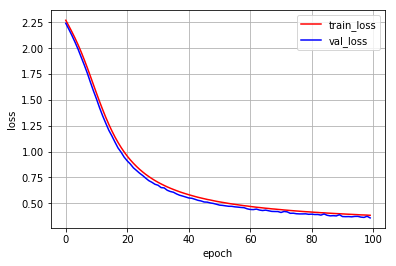

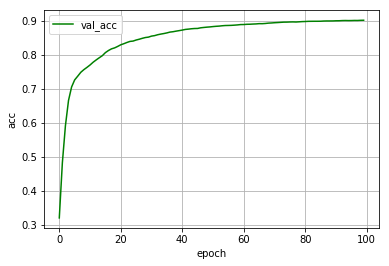

In [14]:
plt.figure()
plt.plot(range(100), loss_list, 'r-', label='train_loss')
plt.plot(range(100), val_loss_list, 'b-', label='val_loss')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.grid()

plt.figure()
plt.plot(range(100), val_acc_list, 'g-', label='val_acc')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('acc')
plt.grid()

In [15]:
a = Variable(iter(test_loader).next()[0].view(-1, 28 * 28).cuda())[0]
a

Variable containing:
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.0000
 0.

In [16]:
outputs = model(a)
outputs

Variable containing:
 7.5822
-5.4427
 1.1578
 2.7127
-6.2160
 4.5641
-1.8519
-1.7551
 1.5943
-2.3275
[torch.cuda.FloatTensor of size 10 (GPU 0)]

In [17]:
outputs.data
torch.max(outputs.data, -1)

(
  7.5822
 [torch.cuda.FloatTensor of size 1 (GPU 0)], 
  0
 [torch.cuda.LongTensor of size 1 (GPU 0)])

In [18]:
outputs.data.max(-1, keepdim=True)

(
  7.5822
 [torch.cuda.FloatTensor of size 1 (GPU 0)], 
  0
 [torch.cuda.LongTensor of size 1 (GPU 0)])